# PCA

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

In [ ]:
df = pd.read_csv("./creditcard.csv")
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
# drop the records with NaN
df = df.dropna()

In [ ]:
# use all but the target as X
X = df.iloc[:,0:-1]
X = (X-X.mean())/X.std()
y = df.iloc[:,-1]

In [ ]:
(train_X,test_X,train_y,test_y) = train_test_split(X,y,train_size=0.8,test_size=0.2,stratify=df.Class,random_state=1)

In [ ]:
# PCA transformation
pca = PCA(n_components=30) 
pca.fit(train_X)

PCA(n_components=30)

In [ ]:
# Name the new features
cols = ['PC-' + str(i+1) for i in range(30)]
PVE = pca.explained_variance_ratio_
PVE = pd.Series(PVE, index = cols)
PVE.head(3)

PC-1    0.065136
PC-2    0.056213
PC-3    0.034551
dtype: float64

<Axes: title={'center': 'PVE'}>

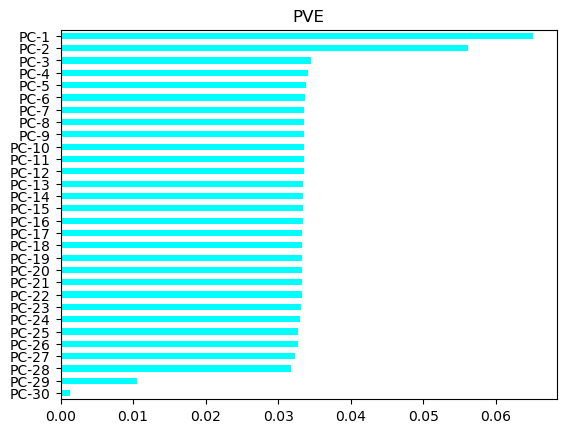

In [ ]:
# Plot the importance of the transformed features
PVE.sort_values().plot.barh(color='cyan', title='PVE')

In [ ]:
# Transform the training set
Xe = pca.transform(train_X)
Xe = pd.DataFrame(Xe, columns=cols)
Xe.head(3)

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-21,PC-22,PC-23,PC-24,PC-25,PC-26,PC-27,PC-28,PC-29,PC-30
0,-0.061635,-1.952267,-0.231373,-0.107294,-0.585698,-1.480510,-1.857227,-1.232102,2.727337,-0.520858,...,0.837848,0.214633,-0.861386,-0.226451,-0.017152,-0.099988,-0.081354,0.069598,-0.482362,-0.000695
1,0.315455,0.780080,-0.079749,-0.327336,-0.183421,-0.744186,0.907958,-1.892088,-0.084758,-0.829259,...,0.544827,0.611485,-1.419356,0.046578,-0.007905,-0.494589,0.363719,-0.833548,0.525091,0.047939
2,-0.376598,-1.185225,0.216025,-0.068051,-0.318715,-0.357769,-0.319273,0.718257,-0.379404,0.858394,...,0.557475,0.218981,-0.748868,0.333051,0.014216,-0.125145,0.082856,0.027089,-0.315310,0.015639


## Using 2 features

In [ ]:
# Selec PC-1 and PC-2
Xe_s = Xe.iloc[:,[0,1]]
Xe_s.head(3)

,PC-1,PC-2
0,0.453978,-2.521585
1,-0.358347,-2.076004
2,1.915713,-2.502902


In [ ]:
# Do a grid search on the number of neighbors
grid = {'n_neighbors': np.arange(1,30)}
knn = KNeighborsClassifier()
knnCV = GridSearchCV(knn, param_grid=grid)

In [ ]:
knnCV.fit(Xe_s,y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [ ]:
# Get the best parameter
knnCV.best_params_

{'n_neighbors': 20}

In [ ]:
# Get the best estimator (n_neighbors = 20)
bestKnn = KNeighborsClassifier(n_neighbors=knnCV.best_params_['n_neighbors'])
bestKnn.fit(Xe_s,train_y)

In [ ]:
# PCA transform the test set
Xe_t = pca.transform(test_X)
Xe_t = pd.DataFrame(Xe_t, columns=cols)
test_score = knnCV.best_estimator_.score(Xe_t.iloc[:,0:28],test_y)

In [ ]:
# Evaluate using different metrics
y_ht = bestKnn.predict(Xe_t.iloc[:,0:28])
print('Confusion Matrix:')
print(confusion_matrix(test_y, y_ht))
print('Accuracy Score:', accuracy_score(test_y, y_ht))
print('Precision Score:', precision_score(test_y, y_ht))
print('Recall Score:', recall_score(test_y, y_ht))
print('F1 Score:', f1_score(test_y, y_ht))
print('roc_auc', roc_auc_score(test_y,y_ht))
print('auprc', average_precision_score(y_true=test_y, y_score=y_ht))

## Using 28 features

In [ ]:
# Selec PC-1 to PC-28
Xe_s = Xe.iloc[:,0:28]
Xe_s.head(3)

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-19,PC-20,PC-21,PC-22,PC-23,PC-24,PC-25,PC-26,PC-27,PC-28
0,-0.061635,-1.952267,-0.231373,-0.107294,-0.585698,-1.480510,-1.857227,-1.232102,2.727337,-0.520858,...,1.697561,1.254748,0.837848,0.214633,-0.861386,-0.226451,-0.017152,-0.099988,-0.081354,0.069598
1,0.315455,0.780080,-0.079749,-0.327336,-0.183421,-0.744186,0.907958,-1.892088,-0.084758,-0.829259,...,-1.361500,-0.023415,0.544827,0.611485,-1.419356,0.046578,-0.007905,-0.494589,0.363719,-0.833548
2,-0.376598,-1.185225,0.216025,-0.068051,-0.318715,-0.357769,-0.319273,0.718257,-0.379404,0.858394,...,0.974175,0.552556,0.557475,0.218981,-0.748868,0.333051,0.014216,-0.125145,0.082856,0.027089


In [ ]:
# Do a grid search on the number of neighbors
grid = {'n_neighbors': np.arange(1,20)}
knn = KNeighborsClassifier()
knnCV = GridSearchCV(knn, param_grid=grid)

In [ ]:
knnCV.fit(Xe_s,train_y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])})

In [ ]:
# Get the best parameter
knnCV.best_params_

{'n_neighbors': 2}

In [ ]:
# Get the best estimator (n_neighbors = 2)
bestKnn = KNeighborsClassifier(n_neighbors=knnCV.best_params_['n_neighbors'])
bestKnn.fit(Xe_s,train_y)

In [ ]:
# PCA transform the test set
Xe_t = pca.transform(test_X)
Xe_t = pd.DataFrame(Xe_t, columns=cols)
test_score = knnCV.best_estimator_.score(Xe_t.iloc[:,0:28],test_y)

In [ ]:
# Evaluate using different metrics
y_ht = bestKnn.predict(Xe_t.iloc[:,0:28])
print('Confusion Matrix:')
print(confusion_matrix(test_y, y_ht))
print('Accuracy Score:', accuracy_score(test_y, y_ht))
print('Precision Score:', precision_score(test_y, y_ht))
print('Recall Score:', recall_score(test_y, y_ht))
print('F1 Score:', f1_score(test_y, y_ht))
print('roc_auc', roc_auc_score(test_y,y_ht))
print('auprc', average_precision_score(y_true=test_y, y_score=y_ht))